# Final Project
## Section 1.3: Mass and Dimensional Testing

### Objective: 

Evaluate the impact of motor masses and dimensions on flight performance (trajectory).

### Most of the information in this section is restated. Skip to the bottom to see the analyses.


### Disclaimer: 

All information obtained regarding the specifics of the Trident D-5 missile has been obtained from available published materials online and in writing. 

### Import Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import pi
plt.rcParams['axes.grid'] = True

### Define Variables

Following values obtained and/or estimated using https://en.missilery.info/missile/trident2

In [3]:
Diam_Norm = 2.11
Z_Norm = 6.720

'https://www.naval-technology.com/projects/trident-ii-d5-fleet-ballistic-missile/'
C_D = 0.295 / 2 # Assumed to be the shape of a bullet + aerospike decreasing drag by 50% 
Tol = 0.1

# Define size dimensions of rocket motor

Radius = Rad = Diam_Norm / 2
A = pi * Rad**2 # Area of rocket interior, equivalent as well to the frontal surface area of the rocket

# Define mass dimensions of rocket motor

S_Mass = 59068 # kg, mass of the fuelled rocket with all three stages
S1_Mass = 37918 # kg, mass of the fuelled first stage

Fuel_Fraction = 0.616 # Fractional share of entire FUELLED rocket's mass by first stage fuel
MFuel_0 = Fuel_Fraction * S_Mass # Starting fuel mass of first stage
m = S1E_Mass = S1_Mass - MFuel_0 # Mass of empty fuel stage 
rho_P = MFuel_0 / (Z_Norm * np.pi * Radius **2)

print("Starting Fuel (kg):", MFuel_0)
print("Chamber Mass (kg):", m)
print("Propellant Density (kg/m^3):", rho_P)

Starting Fuel (kg): 36385.888
Chamber Mass (kg): 1532.112000000001
Propellant Density (kg/m^3): 1548.491812314381


In [4]:
T_C = 1600
MWEff = 36385 / 1190 # Total mass of propellant divided by the effective MW of gas exiting the nozzle, kmol
k = 1.15431 # Calculated using C_P and C_S values from JANAF
P_C = 6890.1 # Chamber pressure, kPa
P_0 = 101.325 # Atmospheric pressure, kPa
a = 1.26 # Constant for pressure
n = 0.4 # Exponent for pressure


rate = a / (100 * (100)**n * (1000)**n) * (P_C)**n

R = 8314 # J / kmol K
U_E = -np.sqrt(2 * T_C * (R/MWEff)*(k/(k - 1))*(1 - (P_0/P_C)**((k - 1)/k)))

print("Burn Rate: (m/s)", rate)
print("Exit Velocity (m/s):", U_E)


Burn Rate: (m/s) 0.004321761090596145
Exit Velocity (m/s): -1675.140347493681


In [5]:
def gravFunc(h):
    G_Constant = 6.67430 * 10**(-11) # m^3 / kg / s^2
    M_Earth = 5.972 * 10**24 # Kilograms
    R_Earth = 6371009 # Meters
    return G_Constant * M_Earth / (R_Earth + h)**2

def atmRhoFunc(h, ρ0=1.225):
    return ρ0 * np.exp(-1e-04*h)


### Preliminary Grain Area Analysis

As we begin our first trajectory analysis, we will need to make estimations for how area may expect to change over a given time. This will be estimated using more sophisticated, intensive analyses downstream, but for now a simple linear increase should suffice. The following data represents the change of area in a circular propellant grain over the course of flight:


In [7]:
row = col = 200
timeburnt = []

def Circle(a, h, k, r0, val, prints = False):
    for c in range(col):
        for r in range(row):
            if c >= h - r0 and c <= h + r0:
                ylimH = k + np.sqrt(r0**2 - (c - h)**2)
                ylimL = k - np.sqrt(r0**2 - (c - h)**2)
                if r <= ylimH and r >= ylimL:
                    a[r][c] = val
    if prints == True:
        print("Starting Propellant Shape:")
        fig = plt.figure(figsize=(3,3))
        im = plt.imshow(Drawing, interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=100)
        plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False) 
        plt.show()
    return a

def tubular(r0, rate, rmax, time, lim=Rad, Z=Z_Norm):
    A = (Z * 2 * pi * (r0 + time * rate))
    if A >= Z * 2 * pi * lim:
        A = 0
    return A
    
def cross(r0, rate, rmax, time, bevel=True):
    if bevel == True:
        BEVEL =  np.sqrt(2 * rate**2 * time**2) - rate * time
    else:
        BEVEL = 0
    if 1-(r0 / 5 + time * rate)**2/Rad**2 > 0:
        A = 8 * Z * Rad * (np.sqrt(1-(r0 / 5 + time * rate)**2/Rad**2) - (r0 + rate * time) / Rad + BEVEL)
    else:
        A = 0
    if A < 0:
        A = 0
    return A

def rod_and_tube(r0, rate, rmax, time):
    margin = 2.55
    
    RA0 = r0*margin
    RB0 = r0*(margin - .1)
    P1 = 2 * pi * ((RA0) + rate*time) 
    P2 = 2 * pi * ((RB0) - rate*time)

    if P1 >= 2 * pi * Rad:
        P1 = 0    
    if P2 < 0:
        P2 = 0
    A = Z * (P1  + P2)
    return A

### Preliminary Trajectory Analyses

We will now employ Forward Euler to make an initial estimation for our flight trajectory.

In [9]:
# Define initial values for ODEs

## h = Altitude of rocket (m)
## V = Velocity of rocket (m/s)
## M = Mass of rocket
## Mf = Mass of fuel (kg)
## g = Gravity, affected by altitude (m/s^2)
## ρ = Density, affected by altitude (kg/m^3)
Vdots = []
term1s = []
term2s = []
term3s = []
rhos = []
Cds = []
As = []
mis = []
mdots = []


def model(t, vals, Areas, fuelzero, n, D1):
    h = vals[0]
    V = vals[1]
    M = vals[2]
    Mf = vals[3]
    g = gravFunc(h)
    ρ = atmRhoFunc(h)
    if ρ > atmRhoFunc(0):
        ρ = atmRhoFunc(0)
    elif ρ < 0:
        ρ = 0
    if g > gravFunc(0):
        g = gravFunc(0)
    elif g < 0:
        g = 0
    
    hdot = V
    if fuelzero == False:
        mDot = -rho_P * np.array(Areas)[1, n] * rate
        
    else:
        mDot = 0
    A = D1 ** 2 / 4 * np.pi
    Vdot = -g - 1/2 * ρ * V * abs(V) * C_D * A / M + mDot * U_E / M

    mfDot = mDot
    
    
    return np.array([hdot, Vdot, mDot, mfDot], dtype=object)



In [10]:
r0 = Diam_Norm/10


h_0 = 0
V_0 = 5
M_0 = S1_Mass - pi * r0**2 * Z_Norm * rho_P
Mf_0 = MFuel_0 - pi * r0**2 * Z_Norm * rho_P

IV = [h_0, V_0, M_0, Mf_0]


def interpolate(x, xList, yList):
    violated = False
    if x in xList:
        loc = np.where(xList == x)
        y = yList[loc]
    else:
        i = 0
        while xList[i] < x:
            i += 1
            if i == len(xList) - 1:
                #print("Outside of limit for x = ", x)
                violated = True
                break
        if violated == False:
            x1 = xList[i-1]
            x2 = xList[i]
            y1 = yList[i-1]
            y2 = yList[i]

            y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
        else:
            y = 0
    return y

def forward(f, times, IV, Areas, D1, H1):
    print("FE Start")
    n = len(times)
    m = len(IV)
    data = np.zeros((n, m))
    data[:][0] = IV
    fuelzero = False
    for i in range(n - 1):
        dt = times[1] - times[0]
        data[:][i+1] = data[:][i] + dt * f (times[i], data[:][i], Areas, fuelzero, i, D1)
        if data[:][i+1][3] < 0: # Account for fuel levels dropping below 0
            data[:][i+1][3] = 0
            fuelzero = True
        if data[:][i+1][1] < 0 and data[:][i+1][0] < 5: # Kill negative velocities if below a groundlevel threshhold
            data[:][i+1][1] = 0
        if data[:][i+1][0] < 0: # Kill negative altitudes if below a groundlevel threshhold
            data[:][i+1][0] = 0  
    return data

def Crank(f, times, IV, Areas, D1, H1):
    print("CN Start")
    n = len(times)
    m = len(IV)
    data = np.zeros((n, m))
    data[:][0] = IV
    fuelzero = False
    for i in range(n - 1):
        dt = times[1] - times[0]
        def resfun(newdata):
            value = newdata - data[i,:] - 0.5 * dt * ( f ( i+1, newdata, Areas, fuelzero, i, D1) + f (i, data[:][i], Areas, fuelzero, i, D1) )
            return value.astype(float)
        data[:][i+1] = fsolve(resfun, data[:][i], full_output=0, )
        if data[:][i+1][3] < 0: # Account for fuel levels dropping below 0
            data[:][i+1][3] = 0
            fuelzero = True
        if data[:][i+1][1] < 0 and data[:][i+1][0] < 5: # Kill negative velocities if below a groundlevel threshhold
            data[:][i+1][1] = 0
        if data[:][i+1][0] < 0: # Kill negative altitudes if below a groundlevel threshhold
            data[:][i+1][0] = 0 
    return data

def plotter(datas, times, labs, index=0, xlab=" ", ylab=" ", legend=True, hlines=[], vlines=[], tmn = 0, tmx = 0, show=True, colors=[], styles=[]):
    default = ['blue', 'red', 'orange', 'green', 'black', 'grey']
    defaultSty = ['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed']
    if tmx == 0:
        tmx = len(times)
    
    for line in hlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axhline(y=line, color=co, lw=width, linestyle=style)
    for line in vlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axvline(y=line, color=co, lw=width, linestyle=style)
    n = 0
    for datum in datas:
        if len(colors) > 0:
            c = colors[n]
        else:
            c = default[n]
        if len(styles) > 0:
            S = styles[n]
        else:
            S = defaultSty[n] 
        plt.plot(times[tmn:tmx], datum[:,index][tmn:tmx]/1000, label=labs[n], color=c, linestyle=S)
        n += 1
    if legend == True:
        plt.legend()
    if xlab != " " or ylab != " ":
        plt.xlabel(xlab)
        plt.ylabel(ylab)
    if show == True:
        plt.show()

#matplotlib.rcParams['figure.dpi'] = 100    




In [12]:


def testDimensions(tmin=0, tmax=1600, inc=1, Diam=Diam_Norm, Height=Z_Norm, Fuel_Fraction=0, 
                   shows=False, Cols=[], Stys=[], tubePlot = False, Cranks=True):
    r0 = Diam / 10
    print(Diam, Diam_Norm, Z, Z_Norm)
    rho_P = 1548.491812314381
    Radius = Rad = Diam / 2
    MFuel_0 = rho_P * (Height * np.pi * Radius **2)
    #S_Mass = MFuel_0 / Fuel_Fraction
    Case_Mass = 1532.112 * Diam / Diam_Norm * Height / Z_Norm
    Fraction = Case_Mass / (Case_Mass + MFuel_0)
    if Fuel_Fraction != 0:
        Case_Mass = MFuel_0 * Fuel_Fraction /(1-Fuel_Fraction)
    
    S1_Mass = Case_Mass + MFuel_0
    
    
    h_0 = 0
    V_0 = 5
    M_0 = S1_Mass - pi * r0**2 * Height * rho_P
    Mf_0 = MFuel_0 - pi * r0**2 * Height * rho_P
    
    IV = [h_0, V_0, M_0, Mf_0]
    print(IV)
    times = np.arange(0, int(tmax), inc)
    tubularAreas = []
    for time in times:
        tubularAreas.append(tubular(r0, rate, Diam/2, time, lim=Radius, Z=Height))
    if tubePlot==True:
        print("Fuel Mass:", Mf_0)
        plt.plot(times, tubularAreas)
        plt.show()
    
    
    if tubePlot == False:
        Areas = [times, tubularAreas]
        data = forward(model, times, IV, Areas, Diam, Height)
        if Cranks == True:
            data2 = Crank(model, times, IV, Areas, Diam, Height)
        else:
            data2 = []
        datas = [data, data2]
        labels = ["FE,","CN,"]
        if Diam != Diam_Norm:
            labels[0] = labels[0]+" D = "+str(Diam)
            labels[1] = labels[1]+" D = "+str(Diam)
        if Height != Z_Norm:
            labels[0] = labels[0]+" Z = "+str(Height)
            labels[1] = labels[1]+" Z = "+str(Height)
        if Fuel_Fraction != 0:
            labels[0] = labels[0]+" Ship:Fuel = "+str(Fuel_Fraction)
            labels[1] = labels[1]+" Ship:Fuel = "+str(Fuel_Fraction)
    
        if Cranks == True:
            plotter(datas, times, labels, colors=Cols, styles=Stys, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
            hlines=[0], vlines=[], tmn = 0, tmx = int(tmax/inc), show=shows)
        else:
            plotter([datas[0]], times, [labels[0]], colors=[Cols[0]], styles=[Stys[0]], index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
            hlines=[0], vlines=[], tmn = 0, tmx = int(tmax/inc), show=shows)
        
    return tubularAreas



In [13]:

Diameter = D = 2.11
Z = Z_Norm
rho_P = 1548.491812314381
Fuel_Fraction = 0.616 # Fractional share of entire FUELLED rocket's mass by first stage fuel
Radius = Rad = Diameter / 2
MFuel_0 = rho_P * (Z * np.pi * Radius **2)
S_Mass = MFuel_0 / Fuel_Fraction
Case_Mass = 1532.112 * D / Diam_Norm * Z / Z_Norm
S1_Mass = Case_Mass + MFuel_0


print("Filled Chamber:", S1_Mass)
print("Fuel Mass:", MFuel_0)
print("Case Mass:", Case_Mass)
print("Fraction Case of FS:", Case_Mass/S1_Mass)

Filled Chamber: 37918.0
Fuel Mass: 36385.888
Case Mass: 1532.112
Fraction Case of FS: 0.040405928582731156


## DIAMETER OF MOTOR EVALUATION

1 2.11 6.72 6.72
[0, 5, 8571.956784438806, 7845.837353159183]
FE Start
2.0 2.11 6.72 6.72
[0, 5, 32835.58827519598, 31383.349412636733]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 36462.56448, 34930.45248]
FE Start
3 2.11 6.72 6.72
[0, 5, 72790.89447227151, 70612.53617843265]
FE Start
4.0 2.11 6.72 6.72
[0, 5, 128437.87537566542, 125533.39765054693]
FE Start
6.0 2.11 6.72 6.72
[0, 5, 286806.8613014083, 282450.1447137306]
FE Start
8.0 2.11 6.72 6.72
[0, 5, 507942.54605242464, 502133.59060218773]
FE Start
10 2.11 6.72 6.72
[0, 5, 791844.9296287146, 784583.7353159183]
FE Start


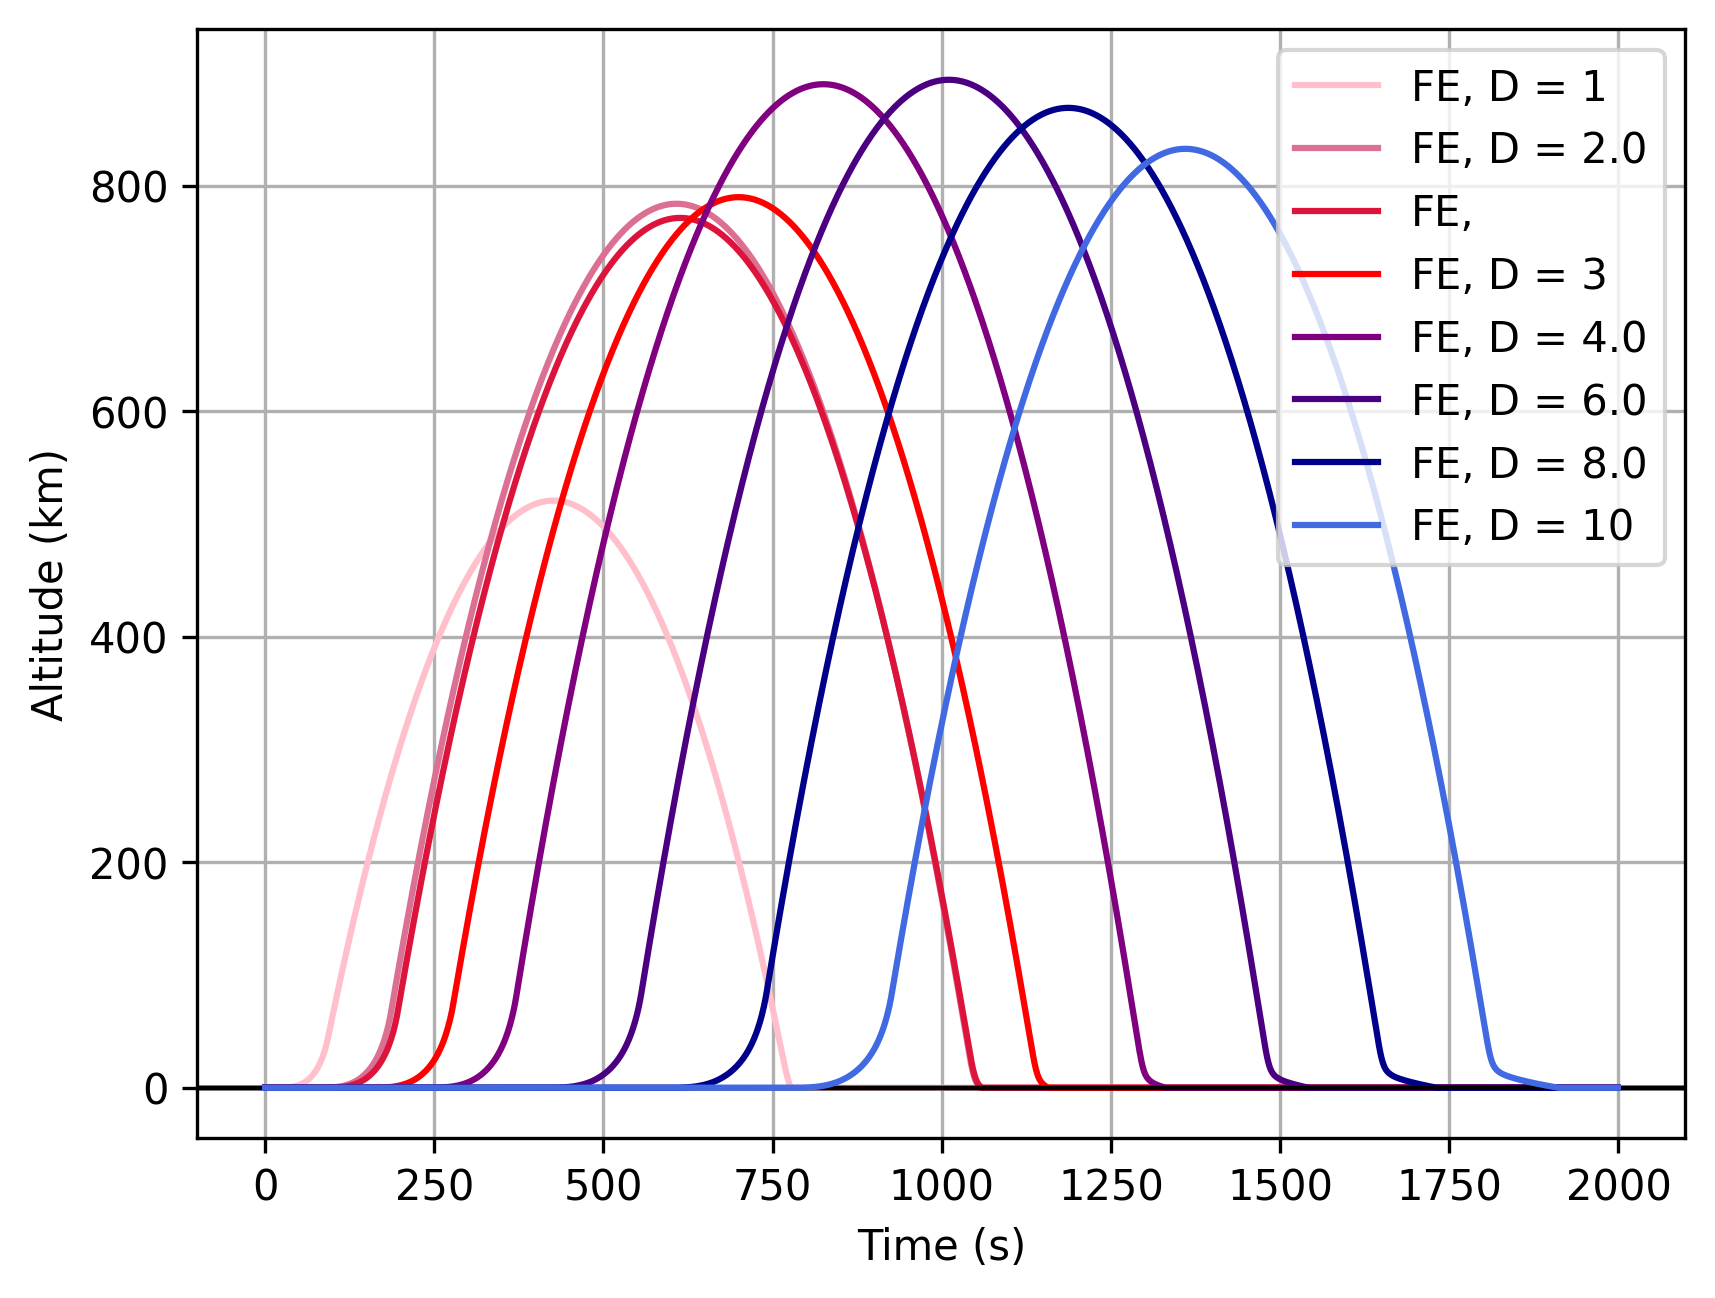

In [15]:
Δt = 1
tmax = 2000
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300   
data = testDimensions(Diam=1, inc=Δt, tmax=tmax, shows=False, Cols=['pink', 'pink'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=2.0, inc=Δt, tmax=tmax, shows=False, Cols=['palevioletred', 'palevioletred'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=2.11, inc=Δt, tmax=tmax, shows=False, Cols=['crimson', 'crimson'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=3, inc=Δt, tmax=tmax, shows=False, Cols=['red', 'red'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=4.0, inc=Δt, tmax=tmax, shows=False, Cols=['purple', 'purple'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=6.0, inc=Δt, tmax=tmax, shows=False, Cols=['indigo', 'indigo'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=8.0, inc=Δt, tmax=tmax, shows=False, Cols=['darkblue', 'darkblue'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Diam=10, inc=Δt, tmax=tmax, shows=True, Cols=['royalblue', 'royalblue'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
 


## HEIGHT OF MOTOR EVALUATION

2.11 2.11 6.72 6.72
[0, 5, 16277.930571428573, 15593.952000000001]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 36462.56448, 34930.45248]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 54259.768571428576, 51979.840000000004]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 81389.65285714285, 77969.76]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 108519.53714285715, 103959.68000000001]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 135649.42142857143, 129949.60000000002]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 162779.3057142857, 155939.52]
FE Start


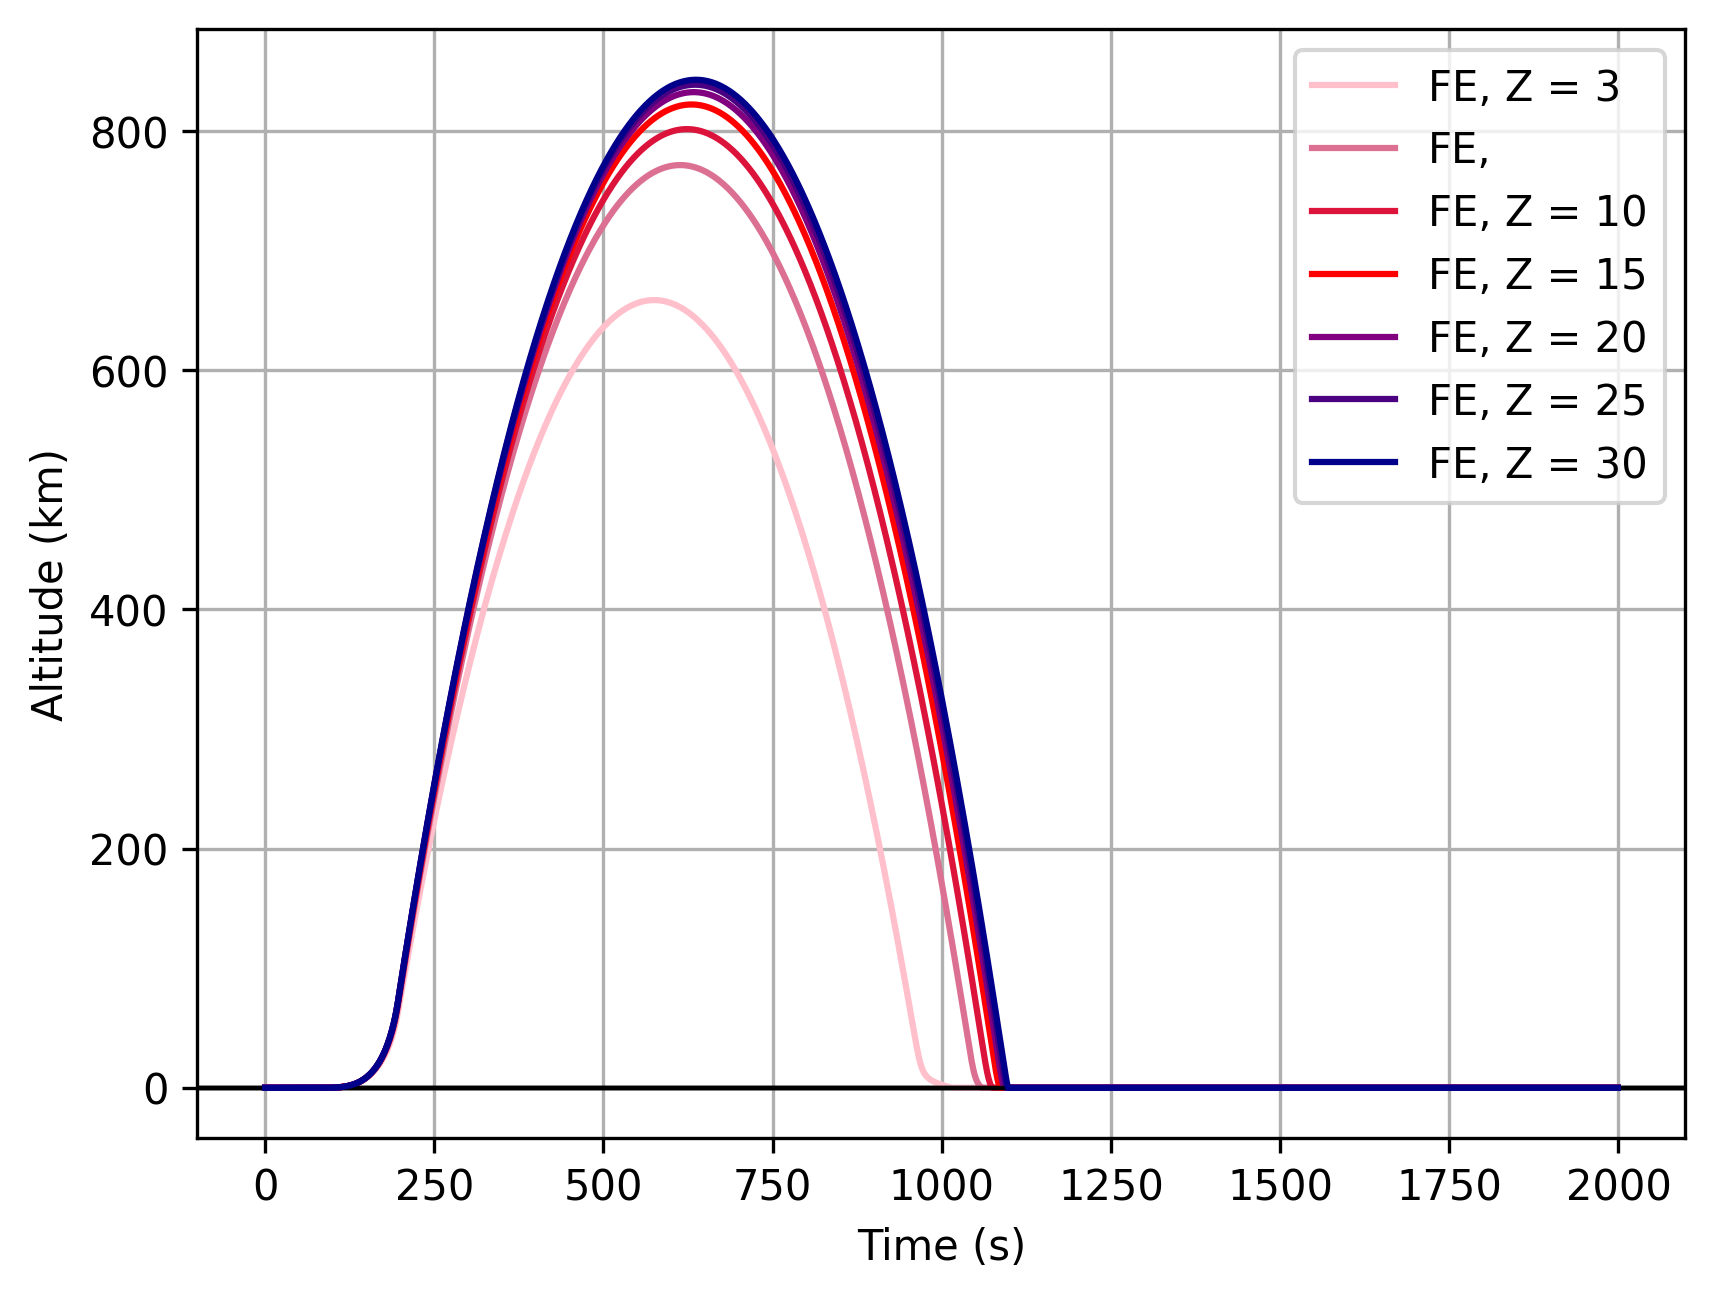

In [25]:
# Z_Norm = 6.720
matplotlib.rcParams['figure.dpi'] = 300   
data = testDimensions(Height=3, inc=Δt, tmax=tmax, shows=False, Cols=['pink', 'pink'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=6.720, inc=Δt, tmax=tmax, shows=False, Cols=['palevioletred', 'palevioletred'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=10, inc=Δt, tmax=tmax, shows=False, Cols=['crimson', 'crimson'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=15, inc=Δt, tmax=tmax, shows=False, Cols=['red', 'red'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=20, inc=Δt, tmax=tmax, shows=False, Cols=['purple', 'purple'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=25, inc=Δt, tmax=tmax, shows=False, Cols=['indigo', 'indigo'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Height=30, inc=Δt, tmax=tmax, shows=False, Cols=['darkblue', 'darkblue'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)


## SHIP HARDWARE FRACTION OF OVERALL MASS EVALUATION

2.11 2.11 6.72 6.72
[0, 5, 35673.021622857144, 34930.45248]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 36462.56448, 34930.45248]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 36845.49921684211, 34930.45248]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 37252.955969361705, 34930.45248]
FE Start
2.11 2.11 6.72 6.72
[0, 5, 38973.328924444446, 34930.45248]
FE Start


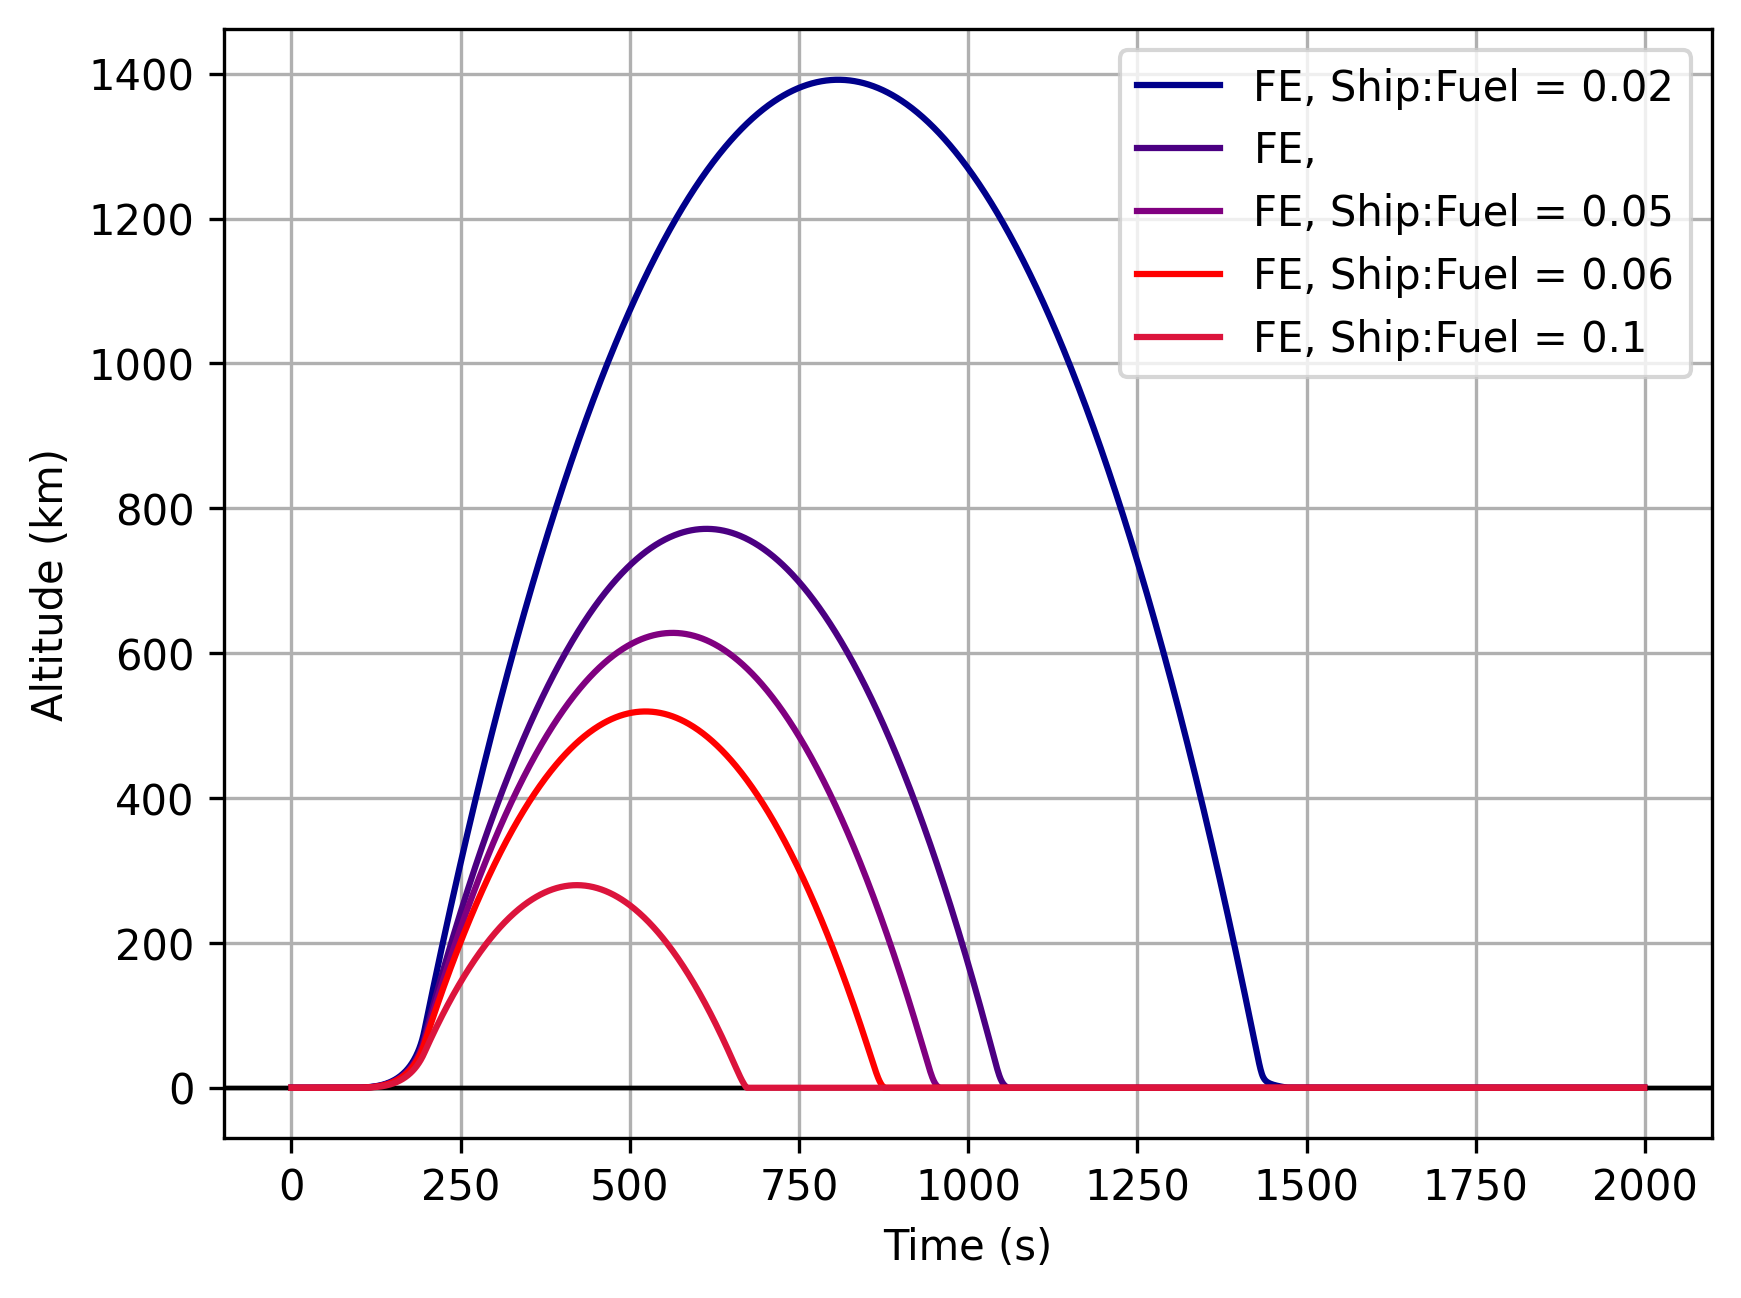

In [31]:
matplotlib.rcParams['figure.dpi'] = 300   
#data = testDimensions(inc=Δt, tmax=tmax, shows=False, Cols=['pink', 'pink'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
#data = testDimensions(Fuel_Fraction=0.000001, inc=Δt, tmax=tmax, shows=False, Cols=['palevioletred', 'palevioletred'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)

data = testDimensions(Fuel_Fraction=0.02, inc=Δt, tmax=tmax, shows=False, Cols=['darkblue', 'darkblue'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(inc=Δt, tmax=tmax, shows=False, Cols=['indigo', 'indigo'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Fuel_Fraction=0.05, inc=Δt, tmax=tmax, shows=False, Cols=['purple', 'purple'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Fuel_Fraction=0.06, inc=Δt, tmax=tmax, shows=False, Cols=['red', 'red'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
data = testDimensions(Fuel_Fraction=0.1, inc=Δt, tmax=tmax, shows=False, Cols=['crimson', 'crimson'], Stys=['solid', 'dashed'], tubePlot=False, Cranks=False)
